In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

import pickle
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, pathlib, time
import PIL
import PIL.Image

from tqdm import tqdm, tqdm_notebook
# from ipywidgets import IntProgress



In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.5.0


In [3]:
# Check for available GPU-
gpu = tf.config.list_physical_devices('GPU')

if len(gpu) == 0:
    print(f"There are no available GPU")
else:
    print(f"Available GPU: {gpu}")

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# os.getcwd()
os.listdir("/content/drive/MyDrive/")

In [ ]:
# Copy zipped image file from Google Drive to Colab directory-
# !unzip "/content/drive/MyDrive/img.zip" -d "/content/"

In [14]:
# Read pickled Python3 list containing 2048-d extracted feature representation per image-
features_list = pickle.load(open("/content/drive/MyDrive/DeepFashion_features_inceptionnetv3.pickle", "rb"))

In [15]:
# Convert from Python3 list to numpy array-
features_list_np = np.asarray(features_list)

features_list_np.shape

(289229, 2048)

In [16]:
del features_list

In [17]:
# Read pickled Python3 list containing abolute path and filenames-
filenames_list = pickle.load(open("/content/drive/MyDrive/DeepFashion_filenames_inceptionnetv3.pickle", "rb"))

In [18]:
features_list_np.shape[0], len(filenames_list)

(289229, 289229)

In [19]:
# Note that the absolute path contains Google colab path-
filenames_list[1]

'/content/img/1981_Graphic_Ringer_Tee/img_00000002.jpg'

In [32]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Sequential([
            InputLayer(input_shape = (2048, )),
            Dense(
                units = 1024, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 512, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 256, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 128, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
        ])
    
        self.decoder = Sequential([
            Dense(
                units = 256, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 512, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 1024, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 2048, activation = 'sigmoid',
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def model(self):
        x = Input(shape=(2048,))
        return Model(inputs = [x], outputs = self.call(x))
    

In [57]:
# Initialize and build defined autoencoder-
model = Autoencoder()
model.build(input_shape = (None, 2048))

In [47]:
model.model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 128)               2787200   
_________________________________________________________________
sequential_5 (Sequential)    (None, 2048)              2789120   
Total params: 5,576,320
Trainable params: 5,576,320
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.summary()

Model: "autoencoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 128)               2787200   
_________________________________________________________________
sequential_5 (Sequential)    (None, 2048)              2789120   
Total params: 5,576,320
Trainable params: 5,576,320
Non-trainable params: 0
_________________________________________________________________


In [49]:
tot_params = 0

for layer in model.trainable_weights:
    loc_param = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_param
    print(f"layer: {layer.shape} has {loc_param} wts")
    

layer: (2048, 1024) has 2097152 wts
layer: (1024,) has 1024 wts
layer: (1024, 512) has 524288 wts
layer: (512,) has 512 wts
layer: (512, 256) has 131072 wts
layer: (256,) has 256 wts
layer: (256, 128) has 32768 wts
layer: (128,) has 128 wts
layer: (128, 256) has 32768 wts
layer: (256,) has 256 wts
layer: (256, 512) has 131072 wts
layer: (512,) has 512 wts
layer: (512, 1024) has 524288 wts
layer: (1024,) has 1024 wts
layer: (1024, 2048) has 2097152 wts
layer: (2048,) has 2048 wts


In [50]:
print(f"Total number of trainable parameters in Autoencoder: {tot_params}")

Total number of trainable parameters in Autoencoder: 5576320


In [58]:
# Sanity check-
x = features_list_np[:5, :]
x.shape

(5, 2048)

In [59]:
x_encoded = model.encoder(x)
x_encoded.shape

TensorShape([5, 128])

In [60]:
x_reconstructed = model.decoder(x_encoded)
x_reconstructed.shape

TensorShape([5, 2048])

In [61]:
# Compile model-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.MeanSquaredError()
    )

In [62]:
# Define early stopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss', min_delta = 0.001, patience = 3, verbose = 0,
    mode = 'auto', baseline = None, restore_best_weights = False
)

In [63]:
# Train autoencoder-
history = model.fit(
    x = features_list_np, y = features_list_np,
    epochs = 10, batch_size = 32,
    callbacks = [early_stopping]
    )

Epoch 1/10
9039/9039 [==============================] - 69s 8ms/step - loss: 6.3852e-04
Epoch 2/10
9039/9039 [==============================] - 67s 7ms/step - loss: 4.8828e-04
Epoch 3/10
9039/9039 [==============================] - 67s 7ms/step - loss: 4.8828e-04
Epoch 4/10
9039/9039 [==============================] - 67s 7ms/step - loss: 4.8828e-04


In [64]:
history.history.keys()

dict_keys(['loss'])

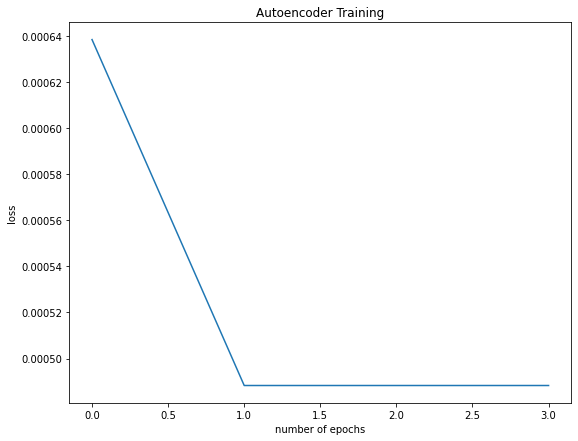

In [66]:
plt.figure(figsize = (9, 7))

plt.plot(history.history['loss'])
plt.title("Autoencoder Training")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()

In [74]:
# Save trained weights of Autoencoder model-
model.save_weights("DeepFashion_InceptionNetV3_Autoencoder_trained_weights.h5", overwrite = True)

In [68]:
x.shape, model.encoder(x).shape

((5, 2048), TensorShape([5, 128]))

In [69]:
range(features_list_np.shape[0])

range(0, 289229)

In [71]:
i = 10
features_list_np[i, :].shape

(2048,)

In [79]:
# model.encoder(features_list_np[0, :])
i = 12
features_list_np[i].reshape(1, 2048).shape

(1, 2048)

Define a Python3 list variable that will store all of the encoded extracted features by appending them.

In [80]:
features_encoded = []

for i in tqdm.notebook.tqdm(range(features_list_np.shape[0])):
# for i in tqdm_notebook(range(features_list_np.shape[0])):
    features_encoded.append(model.encoder(features_list_np[i].reshape(1, 2048)))
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [84]:
# Sanity check-
features_list_np.shape[0], len(features_encoded)

(289229, 289229)

In [85]:
# Write these encoded extracted features to a pickle file so that we can use
# them in the future without having to recalculate them-
pickle.dump(features_encoded, open("DeepFashion_encoded_features_inceptionnetv3.pickle", "wb"))

In [86]:
# Copy extracted features to Google Drive-
!cp DeepFashion_encoded_features_inceptionnetv3.pickle /content/drive/MyDrive/